In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy import stats
from sklearn import svm

In [13]:
from transformers import AutoTokenizer, AutoModel
from bert_transformer import BertTransformer

tokenizer = AutoTokenizer.from_pretrained('allegro/herbert-base-cased')
bert_model = AutoModel.from_pretrained("allegro/herbert-base-cased") 

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.sso.sso_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.sso.sso_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertM

In [14]:
X_string = 'nlp_3', #tuple
Y_string = 'GDT_score'
DATASET = 'NLP_FULLSTOPS.xlsx'

In [15]:
df = pd.read_excel(io=DATASET)

# df = df[df['time'] > 300]
# df = df.reset_index()

bert_transformer = BertTransformer(tokenizer, bert_model, max_length=60)

In [16]:
y = []

for i in range(len(df)):
    if df['GDT_score'][i] in range(4, 8):
        y.append(0)
    elif df['GDT_score'][i] in range(8, 12):
        y.append(1)
    elif df['GDT_score'][i] in range(12, 16):
        y.append(2)
    elif df['GDT_score'][i] in range(16, 21):
        y.append(3)

In [17]:
all_x = []

for item in X_string:

    item_processed = bert_transformer.transform(list(df[item]))
    all_x.append(item_processed)
    print(f'{item} added to list')
    time.sleep(0.5)

all_x = tuple(all_x)
X = np.hstack(all_x)

X.shape

nlp_3 added to list


(522, 768)

In [18]:
pilot_df = pd.read_excel('NLP_PILOT.XLSX')

pilot_X = []
pilot_Y = []

for i in range(len(pilot_df)):
    if pilot_df['GDT_score'][i] in range(4, 8):
        y.append(0)
    elif pilot_df['GDT_score'][i] in range(8, 12):
        y.append(1)
    elif df['GDT_score'][i] in range(12, 16):
        y.append(2)
    elif pilot_df['GDT_score'][i] in range(16, 21):
        y.append(3)

for item in X_string:

    item_processed = bert_transformer.transform(list(pilot_df[item]))
    pilot_X.append(item_processed)
    print(f'{item} added to list')
    time.sleep(0.5)

pilot_X = tuple(pilot_X)
pilot_X = np.hstack(pilot_X)

pilot_X.shape

nlp_3 added to list


(95, 768)

In [105]:
from sklearn.model_selection import KFold
from sklearn.svm import SVC

kfold = KFold(n_splits=10, shuffle=True, random_state=1)

true_data = []
results = []

y = np.asarray(y)

for train_index, test_index in kfold.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))

    vector_clf = SVC(kernel='linear', class_weight=class_weights)
    vector_clf.fit(X_train, y_train)
    result = vector_clf.predict(X_test)

    results = np.concatenate((results, result))
    true_data = np.concatenate((true_data, y_test))

    print(stats.pearsonr(result, y_test))

print('WHOLE DATASET')
print(stats.pearsonr(results, true_data))

PearsonRResult(statistic=0.05240785706244437, pvalue=0.7093766038967237)
PearsonRResult(statistic=0.24226484689518402, pvalue=0.08049878956169389)
PearsonRResult(statistic=0.15061021473115638, pvalue=0.28653292310337475)
PearsonRResult(statistic=0.312264941043496, pvalue=0.024213858758515085)
PearsonRResult(statistic=0.2442735783937227, pvalue=0.08094877590550091)
PearsonRResult(statistic=0.1978537944072423, pvalue=0.15972290411347115)
PearsonRResult(statistic=0.15298059643933232, pvalue=0.27892798744036434)
PearsonRResult(statistic=0.1536133953181924, pvalue=0.2769204957811028)
PearsonRResult(statistic=0.16942640773241976, pvalue=0.22984596620392614)
PearsonRResult(statistic=0.27285358651235625, pvalue=0.05034088925346639)
WHOLE DATASET
PearsonRResult(statistic=0.20207183365522255, pvalue=3.258324058105232e-06)


In [106]:
answers_tuples = [(y, res) for y, res in zip(y, results)]
sorted_tuples = sorted(answers_tuples, key=lambda x: x[0])

test_y = [x[0] for x in sorted_tuples]
result = [x[1] for x in sorted_tuples]

In [107]:
accuracy = sum(np.asarray(result) == test_y) / len(test_y)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.42


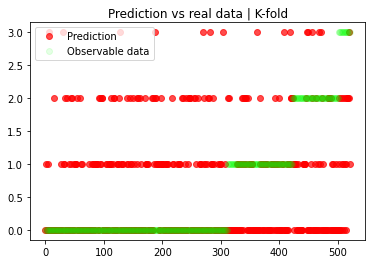

In [108]:
plt.plot(range(len(result)), result, 'o', color=[1, 0, 0, 0.7], label="Prediction")
plt.plot(range(len(test_y)), test_y, 'o', color=[0, 1, 0, 0.1], label='Observable data')
plt.legend(loc='upper left')
plt.title('Prediction vs real data | K-fold')
plt.show()